In [1]:
# nHP = 5, nSN = 20, time limit: 3*3600

In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [3]:
model = gp.Model("DroneDataCollection")

In [4]:

nHP = 5  
nSN = 20 
M   = 5 

I = range(nHP) 
J = range(nSN) 


snp = np.random.rand(nSN, 2) * 1000

In [5]:

y  = model.addVars(I, J, vtype=GRB.BINARY, name="y")                  
h  = model.addVars(nHP, 2, vtype=GRB.CONTINUOUS, name="h")             
d1 = model.addVars(nHP, nSN, vtype=GRB.CONTINUOUS, name="Distance")    
bh = model.addVars(nHP, vtype=GRB.BINARY, name="bh")                  

d2 = model.addVars(nHP, nHP, vtype=GRB.CONTINUOUS, name="Distance")     
tx = model.addVars(nHP, nHP, vtype=GRB.BINARY, name="tx")
u  = model.addVars(nHP, vtype=GRB.CONTINUOUS)

In [6]:

for i in range(nHP):    
    for j in range(nSN):   
        model.addConstr(d1[i, j] >=   h[i, 0] - snp[j, 0] - 1000 * (1-y[i,j]))
        model.addConstr(d1[i, j] >= -(h[i, 0] - snp[j, 0])- 1000 * (1-y[i,j]))
        model.addConstr(d1[i, j] >=   h[i, 1] - snp[j, 1] - 1000 * (1-y[i,j]))
        model.addConstr(d1[i, j] >= -(h[i, 1] - snp[j, 1])- 1000 * (1-y[i,j]))


for i in range(nHP):
    for j in range(nHP):
        if (i == j):
            model.addConstr(d2[i, j] >= 1000*1000)
        else:
            model.addConstr(d2[i, j] >=   h[i, 0] - h[j, 0] - 2000 * (2-bh[i]-bh[j]))
            model.addConstr(d2[i, j] >= -(h[i, 0] - h[j, 0])- 2000 * (2-bh[i]-bh[j]))
            model.addConstr(d2[i, j] >=   h[i, 1] - h[j, 1] - 2000 * (2-bh[i]-bh[j]))
            model.addConstr(d2[i, j] >= -(h[i, 1] - h[j, 1])- 2000 * (2-bh[i]-bh[j]))


In [7]:

model.addConstrs(h[i, 0] >=    0 for i in I)
model.addConstrs(h[i, 0] <= 1000 for i in I)
model.addConstrs(h[i, 1] >=    0 for i in I)
model.addConstrs(h[i, 1] <= 1000 for i in I)
pass

In [8]:

model.addConstrs((gp.quicksum(y[i, j] for i in I) == 1 for j in J), "SensingNodeCoverage")


model.addConstrs((gp.quicksum(y[i, j] for j in J) <= M * bh[i] for i in I), "MaxCoveredSensorsPerHoveringPoint")

pass

In [9]:
# TSP
model.addConstrs((gp.quicksum(tx[i, j] for i in I) == bh[j] for j in I), "TSPConstr1")
model.addConstrs((gp.quicksum(tx[i, j] for j in I) == bh[i] for i in I), "TSPConstr2")
tHP = gp.quicksum(bh[i] for i in I)
for i in range(1, nHP):  
    for j in range(1, nHP): 
        if(i!=j):
            model.addConstr((u[i]-u[j]+tHP*tx[i,j])<=tHP-1)
pass

In [10]:
x1 = gp.quicksum( y[i, j]*d1[i, j] for i in I for j in J) 
x2 = gp.quicksum(tx[i, j]*d2[i, j] for i in I for j in I)  
model.setObjective(x1 + x2, GRB.MINIMIZE)  

In [11]:
data = {'objbnds': [], 'objbsts': [], 'objbstsols': [], 'times': [], 'times_mipsol': []}
def collect_data(model, where):
    if where == gp.GRB.Callback.MIPNODE:

        objbnd = model.cbGet(gp.GRB.Callback.MIPNODE_OBJBND)

        objbst = model.cbGet(gp.GRB.Callback.MIPNODE_OBJBST)
        
        data['objbnds'].append(objbnd)
        data['objbsts'].append(objbst)
        data['times'].append(model.cbGet(gp.GRB.Callback.RUNTIME))
    
    elif where == gp.GRB.Callback.MIPSOL:

        objbstsol = model.cbGet(gp.GRB.Callback.MIPSOL_OBJ)

        data['objbstsols'].append(objbstsol)
        data['times_mipsol'].append(model.cbGet(gp.GRB.Callback.RUNTIME))

In [12]:
model.params.TimeLimit = 3600 * 3
model.optimize(collect_data)

Set parameter TimeLimit to value 10800
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 5600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 540 rows, 270 columns and 1890 nonzeros
Model fingerprint: 0xbfec387d
Model has 125 quadratic objective terms
Model has 12 quadratic constraints
Variable types: 140 continuous, 130 integer (130 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
  QRHS range       [1e+00, 1e+00]
Presolve removed 1 rows and 6 columns
Presolve time: 0.02s
Presolved: 779 rows, 624 columns, 2585 nonzeros
Presolved model has 240 SOS constraint(s)
Variable types: 374 continuous, 250 integer (250 bin

In [13]:

num_vars = model.NumVars
print(f"Number of variables: {num_vars}")

num_constrs = model.NumConstrs
print(f"Number of constraints: {num_constrs}")

m_optimal = model.status == GRB.OPTIMAL
print(f"Is optimal: {m_optimal}")

Number of variables: 270
Number of constraints: 540
Is optimal: False


In [14]:
res_h = np.zeros([nHP, 2])
for i in range(nHP):
    res_h[i, 0] = h[i, 0].X
    res_h[i, 1] = h[i, 1].X
res_bh = np.array([bh[i].X for i in I])

In [15]:
# tsp_dict
tsp_dict = { (i, j): 0 for i in I for j in I }
for i in I:
    for j in I:
        value = model.getVarByName(f"tx[{i},{j}]").x
        tsp_dict[(i, j)] = value

# tans_dict
tans_dict = { (i, j): 0 for i in I for j in J }
for i in I:
    for j in J:
        value = model.getVarByName(f"y[{i},{j}]").x
        tans_dict[(i, j)] = value


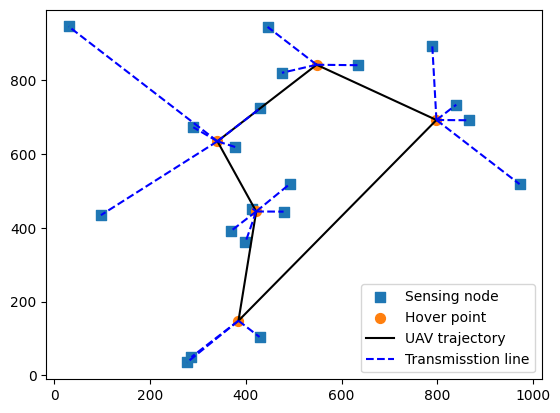

In [16]:
import matplotlib.pylab as plt

res_h2 = res_h[res_bh.astype(bool)]
plt.scatter(snp[:, 0], snp[:, 1], marker='s', s=50, label='Sensing node')
plt.scatter(res_h2[:, 0], res_h2[:, 1], marker='o', s=50, label='Hover point')


route = [key for key,value in tsp_dict.items() if value == 1]
for r in route:
    plt.plot([res_h[r[0],0], res_h[r[1],0]], [res_h[r[0],1], res_h[r[1],1]], 'k-')
line, = plt.plot([], [], 'k-', label="UAV trajectory")


tansr = [key for key,value in tans_dict.items() if value == 1]
for r in tansr:
    plt.plot([res_h[r[0],0], snp[r[1],0]], [res_h[r[0],1], snp[r[1],1]], 'b--')
line, = plt.plot([], [], 'b--', label='Transmisstion line')
plt.legend()
plt.show()

In [ ]:
# import pickle
# with open("data.pickle", 'wb') as f:
#     pickle.dump(data, f)

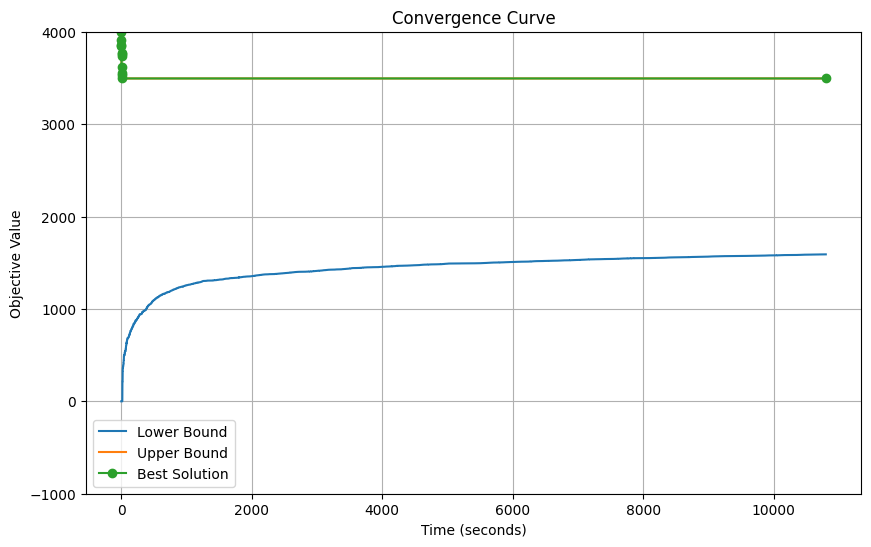

In [4]:
# import pickle
# import matplotlib.pylab as plt
# with open("data.pickle", 'rb') as f:
#     data = pickle.load(f)


plt.figure(figsize=(10, 6))


plt.plot(data['times'], data['objbnds'], label='Lower Bound')


plt.plot(data['times'], data['objbsts'], label='Upper Bound')


plt.plot(data['times_mipsol'], data['objbstsols'], label='Best Solution', marker='o')

plt.xlabel('Time (seconds)')
plt.ylabel('Objective Value')
plt.title('Convergence Curve')
plt.legend()
plt.grid(True)
plt.ylim([-1000, 4000])
plt.show()

In [23]:
snp

array([[428.50811277, 104.35591965],
       [398.90234654, 360.31725312],
       [430.42290136, 724.21482868],
       [276.70188031,  35.25582587],
       [634.26094894, 840.35760427],
       [865.8511827 , 691.25565698],
       [290.06799832, 672.31355564],
       [286.28814634,  50.11306823],
       [445.34201747, 944.10285514],
       [839.70265479, 733.41020595],
       [369.54435567, 392.18464306],
       [789.67308616, 891.2869753 ],
       [ 96.97899844, 434.2391055 ],
       [475.33677709, 819.80225121],
       [413.71594305, 452.09665887],
       [971.99658188, 518.28015121],
       [492.43810738, 519.36775184],
       [478.82417463, 443.76259174],
       [ 29.57051324, 945.26370633],
       [377.65415614, 618.7841599 ]])

In [24]:

count = 0

for i in I:
    row = [round(tans_dict[(i, j)]) for j in J]
    count += sum(row)
    print(row, sum(row))
print(count)

[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] 3
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0] 5
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0] 4
[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 3
[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1] 5
20


In [25]:

count = 0

for i in I:
    row = [round(tsp_dict[(i, j)]) for j in I]
    count += sum(row)
    print(row, sum(row))
print(count)

[0, 0, 0, 0, 1] 1
[0, 0, 0, 1, 0] 1
[1, 0, 0, 0, 0] 1
[0, 0, 1, 0, 0] 1
[0, 1, 0, 0, 0] 1
5


In [26]:

res_h

array([[547.82647265, 841.61839997],
       [421.58615727, 444.22644466],
       [798.28459097, 691.99214213],
       [384.51955527, 148.34447715],
       [340.52114613, 634.31307345]])

In [27]:

res_d = np.zeros([nHP, nSN])
for i in range(nHP):
    for j in range(nSN):
        res_d[i, j] = d1[i, j].X
res_d

array([[  0.        ,   0.        ,   0.        ,   0.        ,
         86.4344763 ,   0.        ,   0.        ,   0.        ,
        102.48445518,   0.        ,   0.        ,   0.        ,
          0.        ,  72.48969556,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  83.90919154,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  52.0418016 ,   0.        ,
          0.        ,   0.        ,   7.87021422,   0.        ,
         75.14130718,  57.23801736,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  67.56659174,   0.        ,   0.        ,
          0.        ,  41.41806382,   0.        , 199.29483318,
          0.        ,   0.        ,   0.        , 173.71199091,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ 43.9885575 ,   0.        ,  

In [28]:

res_d = np.zeros([nHP, nHP])
for i in range(nHP):
    for j in range(nHP):
        res_d[i, j] = d2[i, j].X
res_d

array([[1.00000000e+06, 3.98000000e+02, 2.51000000e+02, 6.94000000e+02,
        2.07305327e+02],
       [5.94509059e+02, 1.00000000e+06, 3.77000000e+02, 2.95881968e+02,
        1.91000000e+02],
       [2.50458118e+02, 3.77000000e+02, 1.00000000e+06, 1.00000000e+03,
        4.58000000e+02],
       [6.94000000e+02, 5.82703200e+02, 5.43647665e+02, 1.00000000e+06,
        4.86000000e+02],
       [1.00000000e+03, 1.90086629e+02, 1.00000000e+03, 1.00000000e+03,
        1.00000000e+06]])

In [29]:
res_bh

array([1., 1., 1., 1., 1.])